<a href="https://colab.research.google.com/github/Phistian/exjobb/blob/main/miguel/plotting/loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup

In [1]:
import sys
from pathlib import Path
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !git clone https://github.com/Phistian/exjobb
  !git config --global user.email "christianrut42@gmail.com"
  !git config --global user.name "Phistian"
  from google.colab import drive
  drive.mount('/content/drive')
  cur_path = Path("/content/exjobb/miguel/training")
else:
  cur_path = Path(__file__)


parent_path = cur_path.parent.resolve()
exjobb_address = str(parent_path) + "/../"
spatial_address = str(parent_path) + '/spatial_gnns/'
datasets_address = str(parent_path) + '/datasets/'
histories_address = str(parent_path) + '/training_results/saved_histories/'
models_address = str(parent_path) + '/training_results/saved_models/'
sys.path.append(spatial_address)
sys.path.append(str(parent_path))

Cloning into 'exjobb'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (382/382), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 1342 (delta 230), reused 270 (delta 145), pack-reused 960
Receiving objects: 100% (1342/1342), 149.00 MiB | 32.56 MiB/s, done.
Resolving deltas: 100% (815/815), done.
Updating files: 100% (282/282), done.
Mounted at /content/drive


In [2]:
%matplotlib inline
!pip install deeptrack --quiet
from importlib import reload
import deeptrack as dt
from deeptrack.models.gnns.graphs import GetEdge
import pandas as pd
import numpy as np

import own_graphs
from own_graphs import GetEdge as custom_ge
from own_graphs import EdgeExtractor as custom_ee
from own_graphs import GraphExtractor as custom_graphE
from own_generators import GraphGenerator as custom_gg
import own_models
import tensorflow as tf
from tensorflow import keras
import random
import matplotlib.pyplot as plt
own_graphs = reload(own_graphs)
from copy import deepcopy
import logging
logging.disable(logging.WARNING)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 26.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 110.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 51.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Load data

In [ ]:
extra_string = 'DATA4model1000'

In [ ]:

model.save(models_address + extra_string)

In [ ]:
import shutil
shutil.make_archive('/content/drive/MyDrive/EXJOBB/models/mpn_trained/DATA1REPORT1000E', 'zip', models_address + extra_string )

'/content/drive/MyDrive/EXJOBB/models/mpn_trained/DATA1REPORT1000E.zip'

In [ ]:
model = keras.models.load_model(models_address + extra_string)

In [63]:
import pandas as pd
simulation_name = "/DATA1/"
my_data = df = pd.read_csv(histories_address + simulation_name + 'losshistory1000.csv', sep=',', index_col=0)

In [64]:
my_data

,loss
0,0.649669
1,0.665880
2,0.686959
3,0.640648
4,0.711962
...,...
595,0.269805
596,0.251833
597,0.246726
598,0.277096


In [26]:
index = np.linspace(400, 1000, len(my_data))

In [32]:
my_data["e"] = (index)

In [33]:
my_data

,0,e
0,0.411129,400.000000
1,0.376228,401.001669
2,0.427362,402.003339
3,0.371058,403.005008
4,0.528710,404.006678
...,...,...
595,0.142500,995.993322
596,0.130758,996.994992
597,0.187355,997.996661
598,0.165559,998.998331


In [61]:
losses = []
vals = []

simulation_name = "DATA1/"
epoch_ends1 = ["200", "400", "1000"]
epoch_ends2 = ["300", "700", "1000"]
epoch_ends3 = ["300", "700", "1000"]
epoch_ends4 = ["1000"]


name_list = ["DATA1/", "DATA2/", "DATA3/", "DATA4/"]
epoch_ends_list = [epoch_ends1, epoch_ends2, epoch_ends3, epoch_ends4]
for i in range(4):
  dfs = []
  epoch_ends = epoch_ends_list[i]
  simulation_name = name_list[i]
  for i in range(len(epoch_ends)):
    df = pd.read_csv(histories_address + simulation_name + 'valhistory' + epoch_ends[i] + '.csv', sep=',', index_col=0)
    if i == 0:
      v = np.linspace(0, int(epoch_ends[i]), len(df))
      df["e"] = v
    else:
      v = np.linspace(int(epoch_ends[i-1]), int(epoch_ends[i]), len(df))
      df["e"] = v
    
    dfs.append(df)

  cdfval = pd.concat(dfs, axis=0)
  vals.append(cdfval)


for i in range(4):
  dfs = []
  epoch_ends = epoch_ends_list[i]
  simulation_name = name_list[i]
  for i in range(len(epoch_ends)):
    df = pd.read_csv(histories_address + simulation_name + 'losshistory' + epoch_ends[i] + '.csv', sep=',', index_col=0)
    if i == 0:
      v = np.linspace(0, int(epoch_ends[i]), len(df))
      df["e"] = v
    else:
      v = np.linspace(int(epoch_ends[i-1]), int(epoch_ends[i]), len(df))
      df["e"] = v
    
    dfs.append(df)

  cdfloss = pd.concat(dfs, axis=0)
  losses.append(cdfloss)

In [66]:
losses

[          loss            e
 0    18.221388     0.000000
 1    16.112211     1.005025
 2    14.535543     2.010050
 3    13.176513     3.015075
 4    11.806114     4.020101
 ..         ...          ...
 595   0.269805   995.993322
 596   0.251833   996.994992
 597   0.246726   997.996661
 598   0.277096   998.998331
 599   0.282962  1000.000000
 
 [1000 rows x 2 columns],
           loss            e
 0    22.779348     0.000000
 1    20.172504     1.003344
 2    18.718225     2.006689
 3    17.252893     3.010033
 4    15.895572     4.013378
 ..         ...          ...
 295   0.208476   995.986622
 296   0.233641   996.989967
 297   0.238581   997.993311
 298   0.192680   998.996656
 299   0.168670  1000.000000
 
 [1000 rows x 2 columns],
           loss            e
 0    34.950218     0.000000
 1    30.952738     1.003344
 2    27.682695     2.006689
 3    24.997192     3.010033
 4    22.351257     4.013378
 ..         ...          ...
 295   0.463199   995.986622
 296   0.437787 

(0.0, 1000.0, -0.3, 8.0)

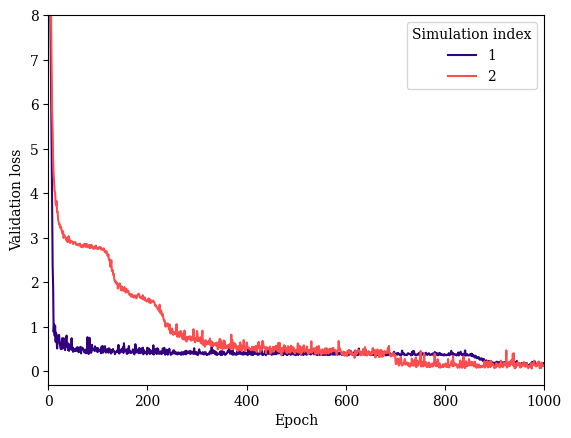

In [125]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['times new roman']
from matplotlib import pyplot as plt
color_v = [[0.2, 0, 0.5], [1, 0.3, 0.3], [0.2, 0, 0.5], [1, 0.3, 0.3]]
linestyle_v = ["dashed", "dotted", "dashdot", "solid"]
for i in range(2):
  plt.plot(vals[i]["e"], vals[i]["0"], color = color_v[i])
plt.legend(["1", "2", "3", "4"], title="Simulation index")
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.axis([0,1000,-0.3, 8])

(0.0, 1000.0, -0.3, 8.0)

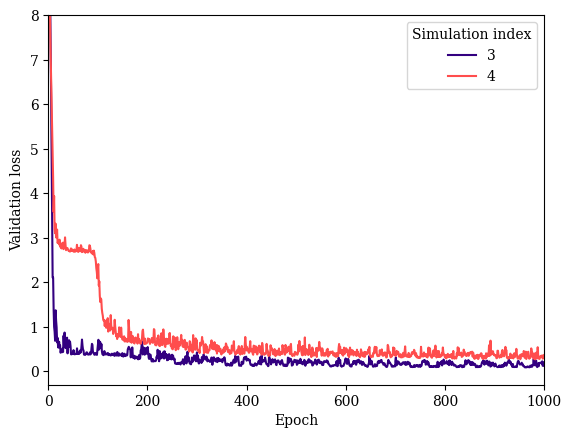

In [120]:
for i in range(2,4):
  plt.plot(vals[i]["e"], vals[i]["0"], color = color_v[i])
plt.legend(["3", "4"], title="Simulation index")
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.axis([0,1000,-0.3, 8])

(0.0, 1000.0, -0.3, 8.0)

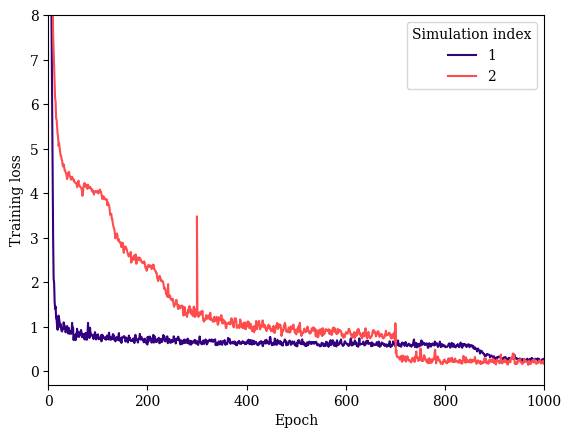

In [126]:
for i in range(2):
  plt.plot(losses[i]["e"], losses[i]["loss"], color = color_v[i])
plt.legend(["1", "2"], title="Simulation index")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.axis([0,1000,-0.3, 8])

(0.0, 1000.0, -0.3, 8.0)

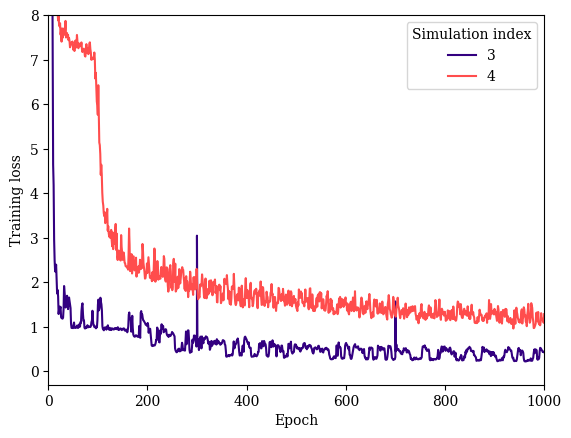

In [127]:
for i in range(2,4):
  plt.plot(losses[i]["e"], losses[i]["loss"], color = color_v[i])
plt.legend(["3", "4"], title="Simulation index")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.axis([0,1000,-0.3, 8])


600